# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

##1. Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors:

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

###Analyzing our data

In [ ]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)

Let's have another look at our previously generated dataset.

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
import warnings
warnings.filterwarnings("ignore")
import time

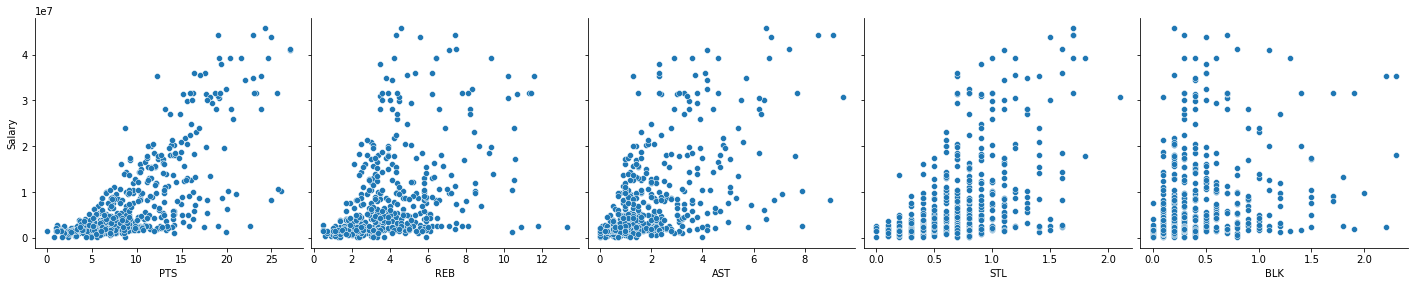

In [ ]:
# The statement below plots the relationship between the players statistics against Salary for each player
sns.pairplot(data, x_vars = ['PTS', 'REB', 'AST', 'STL', 'BLK'], y_vars = 'Salary', height = 4);

1.2. What can we say about these distributions?

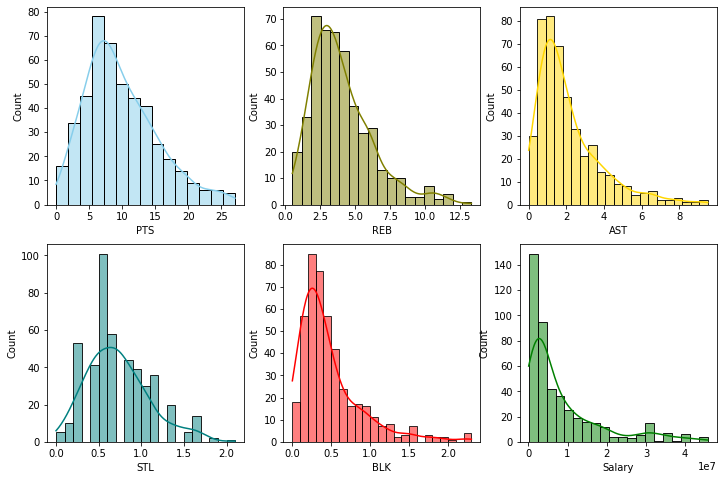

In [ ]:
# The code below plots the distributions
fig, axs = plt.subplots(2, 3, figsize = (12, 8))

sns.histplot(data = data, x = "PTS", kde = True, color = "skyblue", ax = axs[0, 0])
sns.histplot(data = data, x = "REB", kde = True, color = "olive", ax = axs[0, 1])
sns.histplot(data = data, x = "AST", kde = True, color = "gold", ax = axs[0, 2])
sns.histplot(data = data, x = "STL", kde = True, color = "teal", ax = axs[1, 0])
sns.histplot(data = data, x = "BLK", kde = True, color = "red", ax = axs[1, 1])
sns.histplot(data = data, x = "Salary", kde = True, color = "green", ax = axs[1, 2])

plt.show()

Since the right tails (larger values) are much longer than the left tails (small values), then the distributions are skewed right distributions.

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

**Note:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

In [ ]:
# Features (independent variable, explanatory, regressor)
X = data.drop('Salary', axis= 1)
# Labels (dependent variable, explained, response)
y = data['Salary']

# To split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### *Don't change anything in this cell, just make it run correctly*

In [ ]:
if X.SEASON_EXP[322] == 3 and y[255] == 5000000:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

if X.shape == (459, 19) and y.shape == (459,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')


Success!
Success!


### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it.
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving.

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better.

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive an iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [ ]:
class BaselineModel(BaseEstimator):
  """
  A baseline model that always returns the same value, the mean of the
  players salary in the train data
  """

  def fit (self, X_train, y_train):
    """
    Fit the training data.

    Parameters
    ----------
    y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information
    """

    self.value_ = round(np.mean(y), 2)
    return self

  def predict(self, X):
    """
    Predict salaries

    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the

    Returns
    -------
    np.ndarray
        a numpy array of the same length as X, with all elements equal to
        the mean salary calculated in fit()
    """

    out = np.empty(len(X))
    out.fill(self.value_)
    return out

In [ ]:
# Create the model
basemodel = BaselineModel()
basemodel = basemodel.fit(X_train, y_train)

# Test to check that the class BaselineModel worked as expected: "every element should have the same value (the average salary)"
basemodel.predict(X)[:5]

array([8501717.73, 8501717.73, 8501717.73, 8501717.73, 8501717.73])

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [ ]:
# Evaluating model's performance with metric MAE
y_true = y_test
y_pred = basemodel.predict(X_test)
# Baseline MAE
round(mean_absolute_error(y_true, y_pred), 0)

6893061.0

### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [ ]:
# Pipeline to scale data
est = make_pipeline(StandardScaler(), SGDRegressor())

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [ ]:
# Model fitting
est.fit(X_train['PTS'].array.reshape(-1, 1), y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [ ]:
# Evaluating model's performance with metric MAE
y_true_2 = y_test
y_pred_2 = est.predict(X_test['PTS'].array.reshape(-1, 1))
# SGDRegressor with default parameters MAE
round(mean_absolute_error(y_true_2, y_pred_2), 0)

4969810.0

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [ ]:
def search_best_hyperparameters(max_iter, eta0):
  """
    Search for the best hyperparameters.

    Parameters
    ----------
    max_iter: a pandas series or numpy array containing salary information
    eta0: a pandas series or numpy array containing salary information
  """
  from sklearn.model_selection import GridSearchCV
  # Dictionary of hyperparameter values to search
  hyperparameters = {
        'max_iter': max_iter,
        'eta0': eta0
        }
  # GridSearchCV object
  GS = GridSearchCV(estimator = SGDRegressor(),
                  param_grid = hyperparameters,
                  scoring = 'neg_mean_absolute_error', # Scoring (in negative) for the function 'metrics.mean_squared_error'
                  )
  # Fit in the training set
  GS.fit(X_train['PTS'].array.reshape(-1, 1), y_train)
  # Get best hyperparameters values
  best_hyperparameters = 'Best Hyperparamenters: {}'.format(GS.best_params_)

  result = best_hyperparameters

  return result

In [ ]:
# Example list of hyperparameters values
max_iter = [1000, 10000, 10000, 100000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(max_iter, eta0)
print(result)

Best Hyperparamenters: {'eta0': 0.01, 'max_iter': 10000}


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [ ]:
# Pipeline to scale data
est_2 = make_pipeline(StandardScaler(), SGDRegressor(eta0 = 0.0001, max_iter = 100000))

In [ ]:
# Model fitting
est_2.fit(X_train['PTS'].array.reshape(-1, 1), y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor(eta0=0.0001, max_iter=100000))])

In [ ]:
# Evaluating model's performance with metric MAE
y_true_3 = y_test
y_pred_3 = est_2.predict(X_test['PTS'].array.reshape(-1, 1))
# SGDRegressor with default parameters MAE
round(mean_absolute_error(y_true_3, y_pred_3), 0)

4968381.0

In [ ]:
# Dataframe to compare MAE results
pd.DataFrame(
    {
        'Mean Absolute Error': [round(mean_absolute_error(y_true, y_pred), 0), round(mean_absolute_error(y_true_2, y_pred_2), 0), round(mean_absolute_error(y_true_3, y_pred_3), 0)],
    },
    index=[
           'Baseline Model', 'SGDRegressor with Default Parameters', 'Best Combination of Hyperparameters'
    ]
)

,Mean Absolute Error
Baseline Model,6893061.0
SGDRegressor with Default Parameters,4969810.0
Best Combination of Hyperparameters,4968381.0


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the cell that only has the following columns (and player id as an index) and name it mv_regression_df:

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [ ]:
# Create copy of dataframe
mv_regression_df = data[["PERSON_ID","PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "Salary"]].copy().set_index('PERSON_ID')

### *Don't change anything in this cell, just make it run correctly*

In [ ]:
if mv_regression_df.shape == (459, 8):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this:

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [ ]:
# Fill NaN values as undrafted
mv_regression_df.fillna('Undrafted', inplace = True)
# Generate draft using nested if statements
draft = []
for value in mv_regression_df['DRAFT_NUMBER']:
    if value == 'Undrafted':
        draft.append('undrafted')
    else:
        value = int(value)
        if value < 16:
            draft.append('firstround_lottery')
        elif value >= 15 and value < 30:
            draft.append('firstround_non_lottery')
        else:
            draft.append('second_round')

mv_regression_df['DRAFT'] = draft
# Drop the Draft Number column
mv_regression_df.drop('DRAFT_NUMBER', inplace = True, axis=1)

### *Don't change anything in this cell, just make it run correctly*

In [ ]:
if mv_regression_df["DRAFT"].iloc[34] == 'firstround_non_lottery' and mv_regression_df["DRAFT"].iloc[105] == 'undrafted':
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.12. Encode the categorical features: DRAFT, POSITION

In [ ]:
# Generate categorical features for Draft column
d_frl = []
d_frnl = []
d_sr = []
d_ud = []
for value in mv_regression_df['DRAFT']:
    if value == 'firstround_lottery':
        d_frl.append(1)
        d_frnl.append(0)
        d_sr.append(0)
        d_ud.append(0)
    elif value == 'firstround_non_lottery':
        d_frl.append(0)
        d_frnl.append(1)
        d_sr.append(0)
        d_ud.append(0)
    elif value == 'second_round':
        d_frl.append(0)
        d_frnl.append(0)
        d_sr.append(1)
        d_ud.append(0)
    else:
        d_frl.append(0)
        d_frnl.append(0)
        d_sr.append(0)
        d_ud.append(1)

mv_regression_df['DRAFT_firstround_lottery'] = d_frl
mv_regression_df['DRAFT_firstround_non_lottery'] = d_frnl
mv_regression_df['DRAFT_second_round'] = d_sr
mv_regression_df['DRAFT_undrafted'] = d_ud

In [ ]:
# Generate categorical features for Position column
d_forward = []
d_center = []
d_guard = []
for value in mv_regression_df['POSITION']:
    if value == 'Forward':
        d_forward.append(1)
        d_center.append(0)
        d_guard.append(0)
    elif value == 'Center':
        d_forward.append(0)
        d_center.append(1)
        d_guard.append(0)
    else:
        d_forward.append(0)
        d_center.append(0)
        d_guard.append(1)

mv_regression_df['POSITION_Forward'] = d_forward
mv_regression_df['POSITION_Center'] = d_center
mv_regression_df['POSITION_Guard'] = d_guard

### *Don't change anything in this cell, just make it run correctly*

In [ ]:
if mv_regression_df["DRAFT_firstround_non_lottery"].iloc[134] == 0 and mv_regression_df["POSITION_Forward"].iloc[205] == 1:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


#### Modeling

1.13. Split the dataset into train and test.


**Note 1:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

**Note 2:** Remember to drop `DRAFT_NUMBER` column.

In [ ]:
# Features
X = mv_regression_df.drop(['Salary', 'POSITION', 'DRAFT'], axis= 1)
# Labels
y = mv_regression_df['Salary']

# To split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### *Don't change anything in this cell, just make it run correctly*

In [ ]:
if X.BLK.iloc[353] == 0.1 and y.iloc[400] == 4910000:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number (which we will tackle next).

In [ ]:
#Pipeline to scale data
est_mv = make_pipeline(StandardScaler(), SGDRegressor())

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [ ]:
# Model fitting
est_mv.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

1.16. How did the model performed compared to our univariate models?

In [ ]:
# Evaluate model's performance
y_true_4 = y_test
y_pred_4 = est_mv.predict(X_test)
# Calculate MAE of the model
round(mean_absolute_error(y_true_4, y_pred_4), 0)

4919857.0

In [ ]:
# Dataframe to compare MAE results
pd.DataFrame(
    {
        'Mean Absolute Error': [round(mean_absolute_error(y_true, y_pred), 0), round(mean_absolute_error(y_true_2, y_pred_2), 0), round(mean_absolute_error(y_true_3, y_pred_3), 0), round(mean_absolute_error(y_true_4, y_pred_4), 0)],
    },
    index=[
           'Baseline Model', 'SGDRegressor with Default Parameters', 'SGDRegressor with Best Hyperparameters', 'Multivariate Linear Regression'
    ]
)

,Mean Absolute Error
Baseline Model,6893061.0
SGDRegressor with Default Parameters,4969810.0
SGDRegressor with Best Hyperparameters,4968381.0
Multivariate Linear Regression,4919857.0


### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [ ]:
dtm = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 2, max_features = 5)

from sklearn.model_selection import GridSearchCV

param_grid = {"criterion": ["mae"],
              "max_depth": [5, 10, 15, 20, 50],
              "min_samples_leaf": [2, 10, 20, 50],
              "max_features": [5, 10],
              }

#
grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)

grid_cv_dtm.fit(X_train,y_train)

print("Best Hyperparameters: \n{}".format(grid_cv_dtm.best_params_))

Best Hyperparameters: 
{'criterion': 'mae', 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 10}


In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 10, max_features = 10)
regr_1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, max_features=10, min_samples_leaf=10)

1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [ ]:
# Evaluate model's performance
y_true_5 = y_test
y_pred_5 = regr_1.predict(X_test)
# Calculate MAE of the model
round(mean_absolute_error(y_true_5, y_pred_5), 0)

4075131.0

In [ ]:
# Dataframe to compare MAE results
pd.DataFrame(
    {
        'Mean Absolute Error': [round(mean_absolute_error(y_true, y_pred), 0), round(mean_absolute_error(y_true_2, y_pred_2), 0), round(mean_absolute_error(y_true_3, y_pred_3), 0), round(mean_absolute_error(y_true_4, y_pred_4), 0), round(mean_absolute_error(y_true_5, y_pred_5), 0)],
    },
    index=[
           'Baseline Model', 'SGDRegressor with Default Parameters', 'SGDRegressor with Best Hyperparameters', 'Multivariate Linear Regression', 'Decision Tree Regressor with Default Parameters'
    ]
)

,Mean Absolute Error
Baseline Model,6893061.0
SGDRegressor with Default Parameters,4969810.0
SGDRegressor with Best Hyperparameters,4968381.0
Multivariate Linear Regression,4919857.0
Decision Tree Regressor with Default Parameters,4075131.0


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following:

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why?

Multivariate Linear Regression model performed better because the average player's salary is better explained by many factors rather than an specific one.  

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

We could cap the highest salaries (from top players) as they are unique players that provide unique services (like monopolies) that don't reflect the average. Their salary reflects not only their performance, but also services like branding, engage with their fans and even the number of shirts the club will be able to sell. As the salary distribution shows, the income inequality is significant in the NBA just like in many sports (and even in the labor market itself).

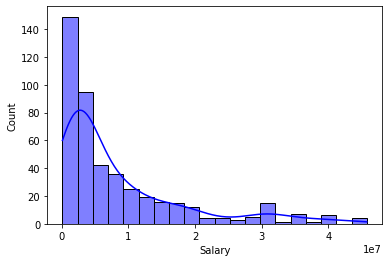

In [ ]:
sns.histplot(data = data, x = "Salary", kde = True, color = "blue");

##2. Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game).
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example).
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

###Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected

In [ ]:
import pandas as pd
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'.

**Note:** Assign your features to `X` variable and labels to `y`.



In [ ]:
# Features
X = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
# Labels
y = all_nba_df['all_nba']

# To split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

### *Don't change anything in this cell, just make it run correctly*

In [ ]:
if X.shape == (14825, 15) and y.shape == (14825,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')

Success!


### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [ ]:
class BaseModel():
  """
  A baseline model that always predicts the same value 0
  """

  def fit(self, y_train):
    """
    Fit the training data.

    Parameters
    ----------
    y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information
    """

    self.y_train = round(y_train.mean(), 0)

  def predict(self, X):
    """
    Predict All-NBA selection

    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the

    Returns
    -------
    np.ndarray
        a numpy array of the same length as X, with all elements equal to 0
    """
    self.X = np.full((len(X), 1), 0)
    return self.X

In [ ]:
basemodel_2 = BaseModel()
# Model fitting
basemodel_2.fit(y_train)
# Evaluating model's performance with metric accuracy
y_true_6 = y_test
y_pred_6 = basemodel_2.predict(X_test)

from sklearn.metrics import accuracy_score
print(f"Accuracy: {round(accuracy_score(y_pred_6, y_true_6), 2)}")

Accuracy: 0.97


2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

Accuracy measures how close is a predicted value to the actual (true) value. For a classification model, it is the measure of all the correctly identified cases. Since 0.97 accuracy is so close to 1, then the model is considered accurate.

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
# Pipeline to scale data
pipeline_lr = make_pipeline(MinMaxScaler(feature_range = (0,1)), LogisticRegression())

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model.

In [ ]:
# Fit del modelo
pipeline_lr.fit(X_train[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']], y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression())])

2.7. Evaluate our baseline model using this metrics:

    - accuracy
    - precision
    - recall
    - f1

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_lr = pipeline_lr.predict(X_test[['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']])
y_true_lr = y_test

# Evaluación de desempeño del modelo con la métrica accuracy
print(f"Accuracy: {round(accuracy_score(y_pred_lr, y_true_lr), 2)}")
print(f"Recall: {round(recall_score(y_pred_lr,y_true_lr), 2)}")
print(f"Precision: {round(precision_score(y_pred_lr,y_true_lr), 2)}")
print(f"F-1 Score: {round(f1_score(y_pred_lr,y_true_lr), 2)}")

Accuracy: 0.98
Recall: 0.89
Precision: 0.51
F-1 Score: 0.65


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall.

### Classification

#### Feature engineering

In [ ]:
classification_df = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba']]
classification_df.dtypes

team             object
games             int64
gamesstarted      int64
mp              float64
fg_perc         float64
3p_perc         float64
2p_perc         float64
ft_perc         float64
trb             float64
ast             float64
stl             float64
blk             float64
tov             float64
pf              float64
pts             float64
all_nba           int64
dtype: object

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [ ]:
# Creates custom ColumnTransformer for the dataframe
numeric_features = ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']
categorical_features = ['team']

preprocessor = ColumnTransformer(
    [
        ('num',
         make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
         numeric_features),
        ('cat',
         OneHotEncoder(),
         categorical_features,
        ),
    ]
)

#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [ ]:
# Features
X = classification_df[['team','games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
# Labels
y = classification_df['all_nba']

# To split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [ ]:
log_reg = make_pipeline(preprocessor, LogisticRegression(random_state = 42))
# Create param grid
grid = {
        'logisticregression__tol': [0.0001, 0.00001, 0.000001, 0.0000001],
        'logisticregression__C': [1, 10, 100, 1000],
        'logisticregression__max_iter': [100, 1000, 10000, 100000]}
#
grid_search = GridSearchCV(estimator = log_reg, param_grid = grid)

In [ ]:
%time grid_search.fit(X_train,y_train)

CPU times: user 2min 26s, sys: 690 ms, total: 2min 26s
Wall time: 2min 37s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['games',
                                                                          'gamesstarted',
                                                                          'mp',
                                                                          'fg_perc',
                                                                      

In [ ]:
# Get best Hyperparameters
print("Best Hyperparameters: \n{}".format(grid_search.best_params_))

Best Hyperparameters: 
{'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__tol': 0.0001}


In [ ]:
y_true_lr = y_test
y_pred_lr = grid_search.predict(X_test)

# Model performance evaluation with metric F1 Score
print(f"F-1 Score: {round(f1_score(y_pred_lr,y_true_lr), 2)}")

F-1 Score: 0.7


In [ ]:
# Report that includes metrics Precision, Recall, F1-Score and Accuracy
from sklearn.metrics import classification_report
print(classification_report(y_pred_lr,y_true_lr))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4773
           1       0.62      0.80      0.70       120

    accuracy                           0.98      4893
   macro avg       0.81      0.89      0.85      4893
weighted avg       0.99      0.98      0.98      4893



#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [ ]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [ ]:
# The statement below merges to the left the all_nba_2018_df on player_id as key with the all_nba_2018_selections
all_nba_2018_df = pd.merge(all_nba_2018_df, all_nba_2018_selections, on='player_id', how='left')

In [ ]:
# Converts all values from categorical columns to dummy values '1' and '0' in new created columns
df_dummies = pd.get_dummies(all_nba_2018_df['team'])

In [ ]:
# Merges the all_nba_2018_df with the df_dummies dataframe with index as keys in order to pass Unit Test below
all_nba_2018_df = pd.merge(all_nba_2018_df, df_dummies, left_index = True, right_index = True)

### *Don't change anything in this cell, just make it run correctly*

In [ ]:
if all_nba_2018_df.shape == (530, 54):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


2.11. Predict and evaluate the model using precision, recall and f1 score.

In [ ]:
# As a Column Transformer capable to impute and escale numerical features and encode categorical features has already been built,
# the previous dataframe (without dummies) will be used for this point

# Read a comma-separated values (csv) file into DataFrames
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

# The statement below merges to the left the all_nba_2018_df on player_id as key with the all_nba_2018_selections
all_nba_2018_df = pd.merge(all_nba_2018_df, all_nba_2018_selections, on='player_id', how='left')

In [ ]:
# Features
X = all_nba_2018_df[['team','games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
# Labels
y = all_nba_2018_df['all_nba']

In [ ]:
log_reg = make_pipeline(preprocessor, LogisticRegression(random_state = 42))
# Create param grid
grid = {
        'logisticregression__tol': [0.0001, 0.00001, 0.000001, 0.0000001],
        'logisticregression__C': [1, 10, 100, 1000],
        'logisticregression__max_iter': [100, 1000, 10000, 100000]}
#
grid_search = GridSearchCV(estimator = log_reg, param_grid = grid)

In [ ]:
%time grid_search.fit(X,y)

CPU times: user 22.3 s, sys: 17.6 s, total: 39.9 s
Wall time: 21.9 s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['games',
                                                                          'gamesstarted',
                                                                          'mp',
                                                                          'fg_perc',
                                                                      

In [ ]:
y_true_lr_2 = y
y_pred_lr_2 = grid_search.predict(X)

# Model performance evaluation with metric F1 Score
print(f"F-1 Score: {round(f1_score(y_pred_lr_2,y_true_lr_2), 2)}")

F-1 Score: 0.89


In [ ]:
# Report that includes metrics Precision, Recall, F1-Score and Accuracy
from sklearn.metrics import classification_report
print(classification_report(y_pred_lr_2,y_true_lr_2))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       518
           1       0.80      1.00      0.89        12

    accuracy                           0.99       530
   macro avg       0.90      1.00      0.94       530
weighted avg       1.00      0.99      0.99       530



2.12. Analyze the results, what do you think it is happening?

The model has improved in each stage getting a better accuracy as the evaluation on the test set data confirmed a close accuracy.

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities.
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [ ]:
prob = grid_search.predict_proba(all_nba_2018_df)
all_nba_2018_df['Proba_Select_All_NBA'] = np.round(prob[:,1], 3)

2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [ ]:
best_probabilities = all_nba_2018_df.sort_values(by = 'Proba_Select_All_NBA', ascending = False)[:15]
best_probabilities

,season_id,player_id,player_season,player_x,season,season_start,team,games,gamesstarted,mp,...,trb,ast,stl,blk,tov,pf,pts,player_y,all_nba,Proba_Select_All_NBA
205,5604,1024,10,James Harden,2018-19,2018,HOU,78,78,36.8,...,6.6,7.5,2.0,0.7,5.0,3.1,36.1,James Harden,1,0.989
17,452,83,6,Giannis Antetokounmpo,2018-19,2018,MIL,72,72,32.8,...,12.5,5.9,1.3,1.5,3.7,3.2,27.7,Giannis Antetokounmpo,1,0.952
257,6841,1240,16,LeBron James,2018-19,2018,LAL,55,55,35.2,...,8.5,8.3,1.3,0.6,3.6,1.7,27.4,LeBron James,1,0.919
505,14479,2648,11,Russell Westbrook,2018-19,2018,OKC,73,73,36.0,...,11.1,10.7,1.9,0.5,4.5,3.4,22.9,Russell Westbrook,1,0.891
149,3908,695,12,Kevin Durant,2018-19,2018,GSW,78,78,34.6,...,6.4,5.9,0.7,1.1,2.9,2.0,26.0,Kevin Durant,1,0.804
182,4891,884,9,Paul George,2018-19,2018,OKC,77,77,36.9,...,8.2,4.1,2.2,0.4,2.7,2.8,28.0,Paul George,1,0.747
154,4145,740,3,Joel Embiid,2018-19,2018,PHI,64,64,33.7,...,13.6,3.7,0.7,1.9,3.5,3.3,27.5,Joel Embiid,1,0.699
268,7225,1315,4,Nikola Jokic,2018-19,2018,DEN,80,80,31.3,...,10.8,7.3,1.4,0.7,3.1,2.9,20.1,Nikola Jokic,1,0.689
304,8206,1511,7,Damian Lillard,2018-19,2018,POR,80,80,35.5,...,4.6,6.9,1.1,0.4,2.7,1.9,25.8,Damian Lillard,1,0.645
123,3168,570,10,Stephen Curry,2018-19,2018,GSW,69,69,33.8,...,5.3,5.2,1.3,0.4,2.8,2.4,27.3,Stephen Curry,1,0.645


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected

In [ ]:
# Players actually selected from the all_nba_2018_selections dataset
selected_players = all_nba_2018_selections[all_nba_2018_selections['all_nba'] == 1]['player']
selected_players

453      Giannis Antetokounmpo
3168             Stephen Curry
3908              Kevin Durant
4145               Joel Embiid
4895               Paul George
5016               Rudy Gobert
5399             Blake Griffin
5604              James Harden
6634              Kyrie Irving
6857              LeBron James
7225              Nikola Jokic
8103             Kawhi Leonard
8206            Damian Lillard
14132             Kemba Walker
14479        Russell Westbrook
Name: player, dtype: object

In [ ]:
# Players actually selected missing from OUR predictions
set(selected_players.values) - set(best_probabilities)

{'Blake Griffin',
 'Damian Lillard',
 'Giannis Antetokounmpo',
 'James Harden',
 'Joel Embiid',
 'Kawhi Leonard',
 'Kemba Walker',
 'Kevin Durant',
 'Kyrie Irving',
 'LeBron James',
 'Nikola Jokic',
 'Paul George',
 'Rudy Gobert',
 'Russell Westbrook',
 'Stephen Curry'}

In [ ]:
# Players in our predictions not selected
set(best_probabilities['player_x']) - set(selected_players.values)

{'Anthony Davis'}

In [ ]:
all_nba_2018_df.drop(labels = ['Proba_Select_All_NBA'], axis  = 1, inplace = True)

2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [ ]:
class AllNbaSingleSeasonClassifier():
  def __init__(self, model):
    """
    Class constructor

    Parameters
    ----------
    model: BaseEstimator
      a Scikit learn estimator
    """
    self._model = model

  def predict(self, X):
    """
    Predicts all nba selections. This classifier will limit the number
    of positive instances to 15

    Parameters
    ----------
    X: pd.DataFrame
      a dataframe with the players data

    Returns
    -------
    np.ndarray
      An array of the same length as y, with 15 true results based on the players with most probabilities of
      beign selected
    """
    data = X.copy()
    proba = self._model.predict_proba(data)
    data['Proba_Select_All_NBA'] = np.round(prob[:,1], 3)
    selections = data.sort_values(by = 'Proba_Select_All_NBA', ascending = False)[:15].index
    data['Prediction'] = 0
    data.loc[selections, ['Prediction']] = 1

    return data['Prediction']

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [ ]:
predictor = AllNbaSingleSeasonClassifier(grid_search)

In [ ]:
predictions = predictor.predict(all_nba_2018_df)

In [ ]:
print(classification_report(all_nba_2018_selections['all_nba'], predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       515
           1       0.93      0.93      0.93        15

    accuracy                           1.00       530
   macro avg       0.97      0.97      0.97       530
weighted avg       1.00      1.00      1.00       530



#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

Consider time played instead of games played, as a starter main player and his substitute both may have the same amount of games, but the starter player could have played 40 minutes and his substitute only 8. So the metrics for points per game are different than metrics like points per minute.

2.19. What do you think we could do to improve our model?

I have read that Cross-validation is useful to improve models, but since it is an advanced technique could have become more work for only one assignment. Also, we could predict 5 forwards, 5 guards and 5 centers in order to be more specific.